In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platform
from matplotlib import font_manager, rc
%matplotlib inline

path = "C:/Windows/Fonts/malgun.ttf"

if platform.system() == "Darwin":
    print("Hangeul OK in your MAC!!!")
    rc("font", family="Arial Unicode MS")
elif platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    print("Hangeul OK in your Windows!!!")
    rc("font", family=font_name)
else:
    print("Unknown system.. sorry~~~")

# 음수일때 오류 나는것 방지
plt.rcParams["axes.unicode_minus"] = False

Hangeul OK in your Windows!!!


## 문제 정의
 6년전 청주 물난리 사태로 인해 금강 인근 지역에 막대한 피해가 발생했습니다. 이러한 피해가 재발되지 않도록 환경청에서 공공 입찰을 통해 문제를 해결하려 했습니다.
 **하천의 범람**은 시민들의 생계를 위협하는 중대한 문제이기 때문에 당시 저희 팀에서는 이런 문제를 해결하기 위해 하천의 **배수구조물들의 배수능력을 검토**하게 되었습니다.

---

## 데이터 수집

- 국토정보지리원에서 데이터 크롤링을 통해 하천 인근 지역의 수치지도를 수집함
    - 수집된 수치지도에는 점과 선으로 된 공간데이터가 들어가 있음
- 유출계수 산정을 위해 필요한 지역의 토지피복도 shp파일을 국가공간정보포털에서 수집함
- 배수시설물의 현 규격을 측량회사로부터 수집함

---

## 데이터 전처리

- 하천을 하나로 보아야하기 때문에 CAD상에서 수치지도 결합
- 공공기관에 납품을 하기위해 수치지도를 GRS80 → Bessel 로 좌표계 변환 (QGIS사용)
- 큰 하천으로 물이 직접적으로 들어가지 않는 배수펌프장과 소하천의 유역계를 제외
- 하천의 유역계(물이 흘러가는 길)를 로드뷰를 보며 판단하여 그리기
    - 이 과정을 통해 각 배수시설물마다 유역계를 확인할 수 있음
- 유역계를 QGIS에 폴리곤 데이터로 생성하고, 토지피복도 shp파일과 **clip**을 통해 특정 지역에 해당하는 토지피복도를 얻을 수 있음


- 해당 지역의 토지피복도와 폴리곤 레이어를 병합하고, 아래의 엑셀파일을 토지피복도 코드를 기준으로 결합시킵니다.

- 필드 계산기를 통해 해당 영역의 면적 ($area)을 추가해줌 (**집수면적** 산정을 위해)
- 위에서 얻은 속성값을 csv파일로 Export한 후 엑셀에서 면적*유출계수 / 집수면적 = 유츨계수 계산을 통해 **유출계수** 산정
- 티센망을 활용한 하천의 지배 관측소 지정

- 유역계 폴리곤 데이터와 티센망을 clip하고 필드 계산기 통해 면적 계산함
- 배수시설물마다 가장 큰 티센망 면적을 가진 관측소를 지베관측소로 지정함
- 지배 관측소에 해당하는 6개의 계수를 강우강도식에 대입하여 **강우강도**를 산정함

---

## 데이터분석

- **분류 모델**: 과부족값을 기준으로 하천의 단면이 적절한지 판단하는 **이진 분류 문제**로 접근할 수 있습니다.
    - 특성 : 유출계수, 강우강도, 집수면적, 현단면
    - 라벨 : 과부족값이 양수인지(즉, 단면이 충분한지) 또는 음수인지(즉, 단면이 부족한지)를 나타내는 이진 값
    - 분류 모델: Logistic Regression, Decision Tree, Random Forest, LGBM, XGBoost

---

In [61]:
# 금천, 구룡천, 길산천 데이터
df = pd.read_excel("./배수능력검토_모델링.xlsx", header=0, index_col=0)
df.head()

,현단면,유출계수,강우강도,집수면적,과부족
배수시설명,0.79,0.77,50.150366,0.033609,0.62
금천제1배수통관,0.79,0.78,38.588700,0.036453,0.64
금천제2배수통관,3.00,0.74,54.986181,0.127314,2.31
금천제1배수문,1.13,0.76,46.802044,0.042033,0.93
금천제3배수통관,2.25,0.75,51.702577,0.059872,1.94


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 335 entries, 배수시설명 to 길산제72배수통관
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   현단면     335 non-null    float64
 1   유출계수    335 non-null    float64
 2   강우강도    335 non-null    float64
 3   집수면적    335 non-null    float64
 4   과부족     335 non-null    float64
dtypes: float64(5)
memory usage: 15.7+ KB


---

### 데이터 전처리

- 과부족값을 라벨로 놓고 나머지 칼럼은 특성값임
- 과부족이 0 이상일때는 배수시설물을 존치하고 음수일때는 배수시설물 재가설(홍수 위험)
- 따라서 분류 모델로 예측하기 위해 0 이상일 때 1, 음수일 때 0 으로 처리함


In [63]:
# 과부족 column 전처리
df["과부족"] = [1 if s>=0 else 0 for s in df["과부족"]]
df

,현단면,유출계수,강우강도,집수면적,과부족
배수시설명,0.79,0.77,50.150366,0.033609,1
금천제1배수통관,0.79,0.78,38.588700,0.036453,1
금천제2배수통관,3.00,0.74,54.986181,0.127314,1
금천제1배수문,1.13,0.76,46.802044,0.042033,1
금천제3배수통관,2.25,0.75,51.702577,0.059872,1
...,...,...,...,...,...
길산제68배수통관,0.50,0.78,33.777446,0.065009,1
길산제69배수통관,0.50,0.78,37.932066,0.019197,1
길산제70배수통관,0.50,0.78,50.604614,0.067655,1
길산제71배수통관,0.79,0.72,48.983890,0.096836,1


In [64]:
# 특성 객체만 numpy 배열로 변환
np_df = df.iloc[:, :4].to_numpy()
np_df

array([[7.90000000e-01, 7.70000000e-01, 5.01503662e+01, 3.36094060e-02],
       [7.90000000e-01, 7.80000000e-01, 3.85886997e+01, 3.64531030e-02],
       [3.00000000e+00, 7.40000000e-01, 5.49861811e+01, 1.27314104e-01],
       ...,
       [5.00000000e-01, 7.80000000e-01, 5.06046137e+01, 6.76546220e-02],
       [7.90000000e-01, 7.20000000e-01, 4.89838905e+01, 9.68359490e-02],
       [2.00000000e-01, 6.80000000e-01, 2.73567986e+01, 4.19195690e-02]])

- 특성간의 척도 차이가 커서 이를 제거하기 위해 정규화시킴

In [65]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss_data = ss.fit_transform(np_df)
ss_data

array([[-0.30628504,  0.35181828,  1.61509341, -0.42089496],
       [-0.30628504,  0.58613066,  0.4339729 , -0.41694847],
       [ 0.06237342, -0.35111884,  2.10911217, -0.29085143],
       ...,
       [-0.35466104,  0.58613066,  1.66149858, -0.37364695],
       [-0.30628504, -0.81974359,  1.4959282 , -0.33314906],
       [-0.40470517, -1.75699309, -0.71345932, -0.4093621 ]])

---

###  현단면, 유출계수, 강우강도, 집수면적 4개의 feature를 모두 사용 

- 과적합되는 것을 막기 위해 train, test 데이터로 나누어서 모델을 학습

In [66]:
from sklearn.model_selection import train_test_split

X = ss_data
y = df["과부족"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [67]:
# 클래스별 개수 확인
np.unique(y_test, return_counts=True)

(array([0, 1], dtype=int64), array([11, 56], dtype=int64))

In [68]:
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([ 31, 237], dtype=int64))

### DecisionTree 사용

- 클래스 불균형이 있는 데이터셋에서 0(홍수 위험 시설물)을 잡아내는 것이 중요함
- 따라서 재현율(Recall)이나 F1 점수(F1 Score)가 유용한 지표
- Stratified K-fold Cross-validation 사용하여 교차검증할 것임
- 분류 문제에서, 특히 불균형 데이터 세트에서 유용하기 때문에 쓰는것

In [69]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

skfold = StratifiedKFold(n_splits=5)
dt = DecisionTreeClassifier(max_depth=6, random_state=13)

# 교차 검증을 위한 설정
scoring = ['recall', 'f1']

# `cross_validate` 함수를 사용하여 교차 검증 수행
dt_scores = cross_validate(dt, X, y, scoring=scoring, cv=skfold, return_train_score=False)

dt_mean_recall = np.mean(dt_scores['test_recall'])
dt_mean_f1 = np.mean(dt_scores['test_f1'])

print(f"Average test Recall: {dt_mean_recall:.4f}")
print(f"Average test F1 Score: {dt_mean_f1:.4f}")

# 특성의 중요도 파악
dt.fit(X_train, y_train)
dt_importances = dt.feature_importances_

Average test Recall: 0.9524
Average test F1 Score: 0.9409


- 특성의 중요도는 각 노드에서의 특성 선택으로 인한 불순도 감소의 총 합계를 기반으로 계산
- 불순도 감소가 클수록 분류가 잘 되었다는 뜻이므로 현단면이 과부족값을 분류하는데 가장 중요한 값임

=> 하천의 범람은 그 물을 담을 그릇의 용적이 부족하여 발생되기 때문에 충분히 설득력있는 수치임

### Random Forest

In [70]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=13, n_jobs=-1, n_estimators=100)


# `cross_validate` 함수를 사용하여 교차 검증 수행
rf_scores = cross_validate(rf, X, y, scoring=scoring, cv=skfold, return_train_score=False)

rf_mean_recall = np.mean(rf_scores['test_recall'])
rf_mean_f1 = np.mean(rf_scores['test_f1'])


print(f"Average test Recall: {rf_mean_recall:.4f}")
print(f"Average test F1 Score: {rf_mean_f1:.4f}")

rf.fit(X_train, y_train)
rf_importances = rf.feature_importances_

Average test Recall: 0.9728
Average test F1 Score: 0.9423


### LightGBM

In [71]:
from lightgbm import LGBMClassifier


# 가장 성능이 좋을때의 파라미터
lgbm = LGBMClassifier(n_estimators=100, learning_rate=0.9, max_depth=3)

# `cross_validate` 함수를 사용하여 교차 검증 수행
lgbm_scores = cross_validate(lgbm, X, y, scoring=scoring, cv=skfold, return_train_score=False)

lgbm_mean_recall = np.mean(lgbm_scores['test_recall'])
lgbm_mean_f1 = np.mean(lgbm_scores['test_f1'])





lgbm.fit(X_train, y_train)
lgbm_importances = lgbm.feature_importances_

print(f"Average test Recall: {lgbm_mean_recall:.4f}")
print(f"Average test F1 Score: {lgbm_mean_f1:.4f}")


[LightGBM] [Info] Number of positive: 234, number of negative: 34
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220
[LightGBM] [Info] Number of data points in the train set: 268, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.873134 -> initscore=1.928961
[LightGBM] [Info] Start training from score 1.928961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

### XGBoost

In [72]:
from xgboost import XGBClassifier

# 가장 성능이 좋을 때의 파라미터
xgb = XGBClassifier(n_estimators=70, learning_rate=0.5, max_depth=2)

# `cross_validate` 함수를 사용하여 교차 검증 수행
xgb_scores = cross_validate(xgb, X, y, scoring=scoring, cv=skfold, return_train_score=False)

xgb_mean_recall = np.mean(xgb_scores['test_recall'])
xgb_mean_f1 = np.mean(xgb_scores['test_f1'])


print(f"Average test Recall: {xgb_mean_recall:.4f}")
print(f"Average test F1 Score: {xgb_mean_f1:.4f}")

xgb.fit(X_train, y_train)
xgb_importances = xgb.feature_importances_


Average test Recall: 0.9762
Average test F1 Score: 0.9566


 이제 모든 분류기를 한 번에 성능을 비교해보자

In [73]:
# 테스트 데이터만 비교

print("Decision Tree")
print(f"Average test Recall: {dt_mean_recall:.4f}")
print(f"Average test F1 Score: {dt_mean_f1:.4f}")
print("~"*30)
print("Random Forest")
print(f"Average test Recall: {rf_mean_recall:.4f}")
print(f"Average test F1 Score: {rf_mean_f1:.4f}")
print("~"*30)
print("LightGBM")
print(f"Average test Recall: {lgbm_mean_recall:.4f}")
print(f"Average test F1 Score: {lgbm_mean_f1:.4f}")
print("~"*30)
print("XGBoost")
print(f"Average test Recall: {xgb_mean_recall:.4f}")
print(f"Average test F1 Score: {xgb_mean_f1:.4f}")



Decision Tree
Average test Recall: 0.9524
Average test F1 Score: 0.9409
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Random Forest
Average test Recall: 0.9728
Average test F1 Score: 0.9423
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
LightGBM
Average test Recall: 0.9693
Average test F1 Score: 0.9530
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
XGBoost
Average test Recall: 0.9762
Average test F1 Score: 0.9566


---

## 특성의 중요도 파악

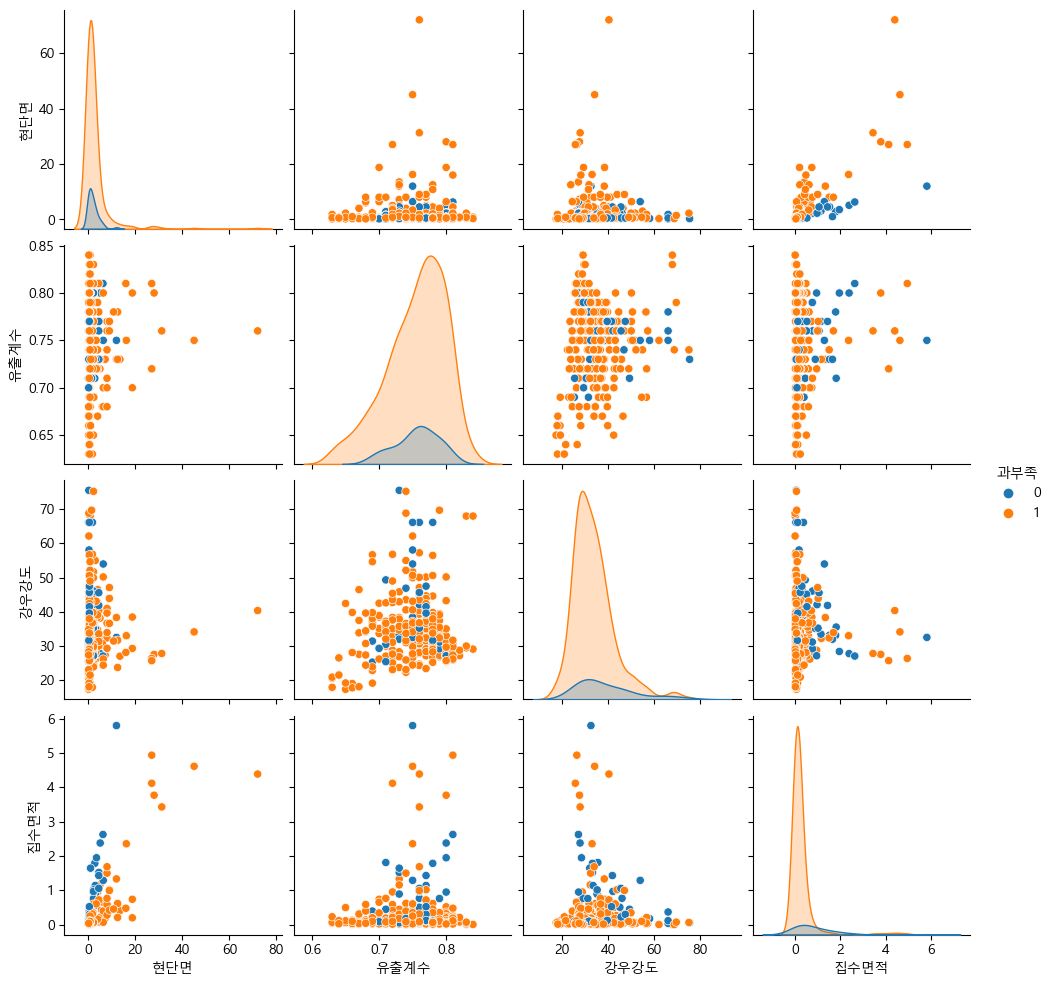

In [74]:
sns.pairplot(data=df, hue="과부족");

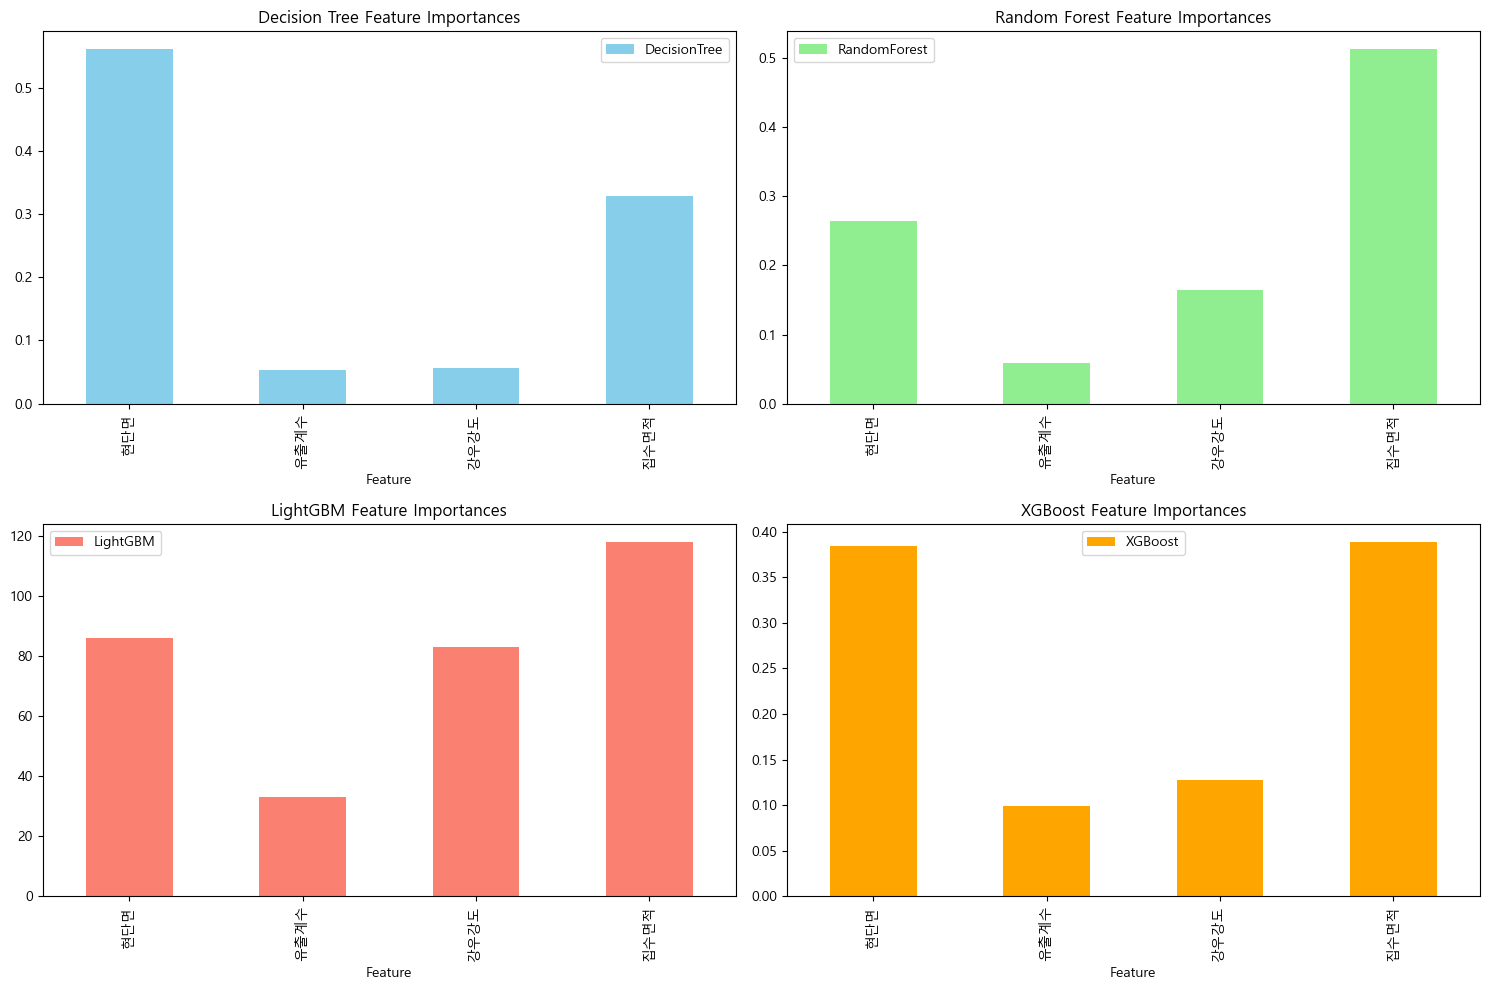

In [75]:
# 특성 이름
feature_names = ['현단면', '유출계수', '강우강도', '집수면적']

# 특성 중요도 데이터 프레임 생성
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'DecisionTree': dt_importances,
    'RandomForest': rf_importances,
    'LightGBM': lgbm_importances,
    'XGBoost': xgb_importances
})

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
importances_df.plot(kind='bar', x='Feature', y='DecisionTree', ax=axes[0, 0], color='skyblue')
importances_df.plot(kind='bar', x='Feature', y='RandomForest', ax=axes[0, 1], color='lightgreen')
importances_df.plot(kind='bar', x='Feature', y='LightGBM', ax=axes[1, 0], color='salmon')
importances_df.plot(kind='bar', x='Feature', y='XGBoost', ax=axes[1, 1], color='orange')

axes[0, 0].set_title('Decision Tree Feature Importances')
axes[0, 1].set_title('Random Forest Feature Importances')
axes[1, 0].set_title('LightGBM Feature Importances')
axes[1, 1].set_title('XGBoost Feature Importances')

plt.tight_layout()
plt.show()


1. 현단면과 집수면적의 중요성: 이들은 모델에서 일관되게 높은 중요도를 보여줍니다. 이를 이해하기 위해, 물이 넘치는 컵을 생각해볼 수 있습니다. 만약 컵의 용적이 들어가야 할 물의 양에 비해 작다면, 즉 현단면과 집수면적이 충분하지 않다면, 홍수가 발생할 가능성이 높아집니다. 이는 물의 양과 그것을 담을 공간의 크기 사이의 관계를 강조합니다.

2. 유출계수의 상대적 중요도: 유출계수는 땅이 물을 얼마나 흡수하지 않고 바로 유출시키는지를 나타냅니다. 이를 화분에 물을 주는 상황에 비유해 생각해볼 수 있습니다. 화분 밑에 자갈이 있거나 흙이 촘촘할 때 물의 배출 속도에 영향을 미치겠지만 절대적인 물의 양에 큰 영향을 주지 못합니다. 이는 유출계수가 모델에서 상대적으로 낮은 중요도를 가질 수 있음을 설명합니다.

3. 강우강도의 중요도: 강우강도는 화분에 물을 주는 속도에 비유될 수 있습니다. 단시간에 많은 물을 주느냐, 아니면 장시간에 걸쳐 조금씩 물을 주느냐는 절대적인 물의 양에 큰 영향을 주지 못합니다. 이는 강우강도가 홍수 예측에서 상대적으로 중요도가 떨어질 수 있음을 시사합니다.

---

## 결론

- 이와 같은 결과를 통해 현단면과 집수면적을 중점적으로 보완하려고 하는데 현실적으로 집수면적을 줄이려면 새로운 배수시설물의 개수를 늘려야 한다.
    => 새로운 지역에 시설물을 설치한다는 것은 주변 주민들에게 보상비용을 제공해야 된다.
- 이는 환경청에 제안서를 제출할 때 비용적인 측면에서 타 회사에 비해 경쟁력이 떨어지게 되므로 현단면을 보강하는 것을 목표로 해야 한다.
- 따라서 배수통관 규격을 D800 에서 D1200 으로 바꾸거나 시설물을 여러개 붙여놓는 방식으로 배수능력을 향상시켜 환경청에 분석결과를 제출하여 수주에 성공할 수 있었다.